In [1]:
%%HTML

<link rel="stylesheet" href="rise.css"/>

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import numpy as np
from em_utilities import get_loop_sim, JBPlotter
from geoana.em.tdem import simple_functions
from ipywidgets import interact, IntSlider
from IPython.display import display
from simpeg.electromagnetics import time_domain as tdem

plt.rcParams['figure.figsize'] = [6.4, 4.2]
plt.rcParams['figure.dpi'] = 300

In [3]:
sim = get_loop_sim()
source = sim.survey.source_list[0]
field = sim.fields(None)

I:\anaconda3\envs\simulation\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


In [4]:
plotter = JBPlotter(sim, field[source, "j"], field[source, "b"], [-200, 200], [-300, 10])

# Time Domain EM (TDEM/TEM) Fundamentals and Instrumentation

Topics
* EM theory applied to the time domain EM experiment
* Collecting TDEM data

## TDEM Physics


Consider a loop of wire laying on the Earth's surface with a **constant** current running through it.

<div class='row'>
<div class='column'>

* Electrical current creates a magnetic field.
* Stength of the field depends on the current and size of the loop (it's magnetic moment).
</div>
<div class='column'>

![ProTEM](resources/2-tx-example.png "ProTEM HF3D Rx")
</div>
</div>



What happens when we turn off the current?!

> **Remember**
>
> Nature wants to preserve magnetic fields!

**Induction!**

In [5]:
interact(plotter.do_plot, time_index=IntSlider(1, 1, 40));

interactive(children=(IntSlider(value=1, description='time_index', max=40, min=1), Output()), _dom_classes=('w…

* At the **instant** the current is turned off:
    * An image of the wire's current is in the subsurface s.t. the $B$-field is the same.
* It then decays downward and outwards
    * Energy disipates due to ohmic heat loss (Diffusion!)
    * Smoke rings

#### B-field at the center
* At the center of the loop, the $B$ field is the strongest.
* If earth is 1D there will only be a z-component of $B$

In [6]:
def do_b_plot():
    ts = np.logspace(-8,-2)
    #ts = np.linspace(0, 0.001, 256)
    
    bz2 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=0.1)
    plt.plot(ts, bz2, label=r'$\sigma=0.1$')
    
    bz1 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=1)
    plt.plot(ts, bz1, label=r'$\sigma=1$')
    
    bz3 = simple_functions.vertical_magnetic_flux_horizontal_loop(ts, sigma=10)
    plt.plot(ts, bz3, label=r'$\sigma=10$')
    plt.legend()
    plt.xlabel('time (s)')
    plt.ylabel('B-field (T)')
    plt.title('Magnetic flux density at the center of the transmitter loop')
    
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

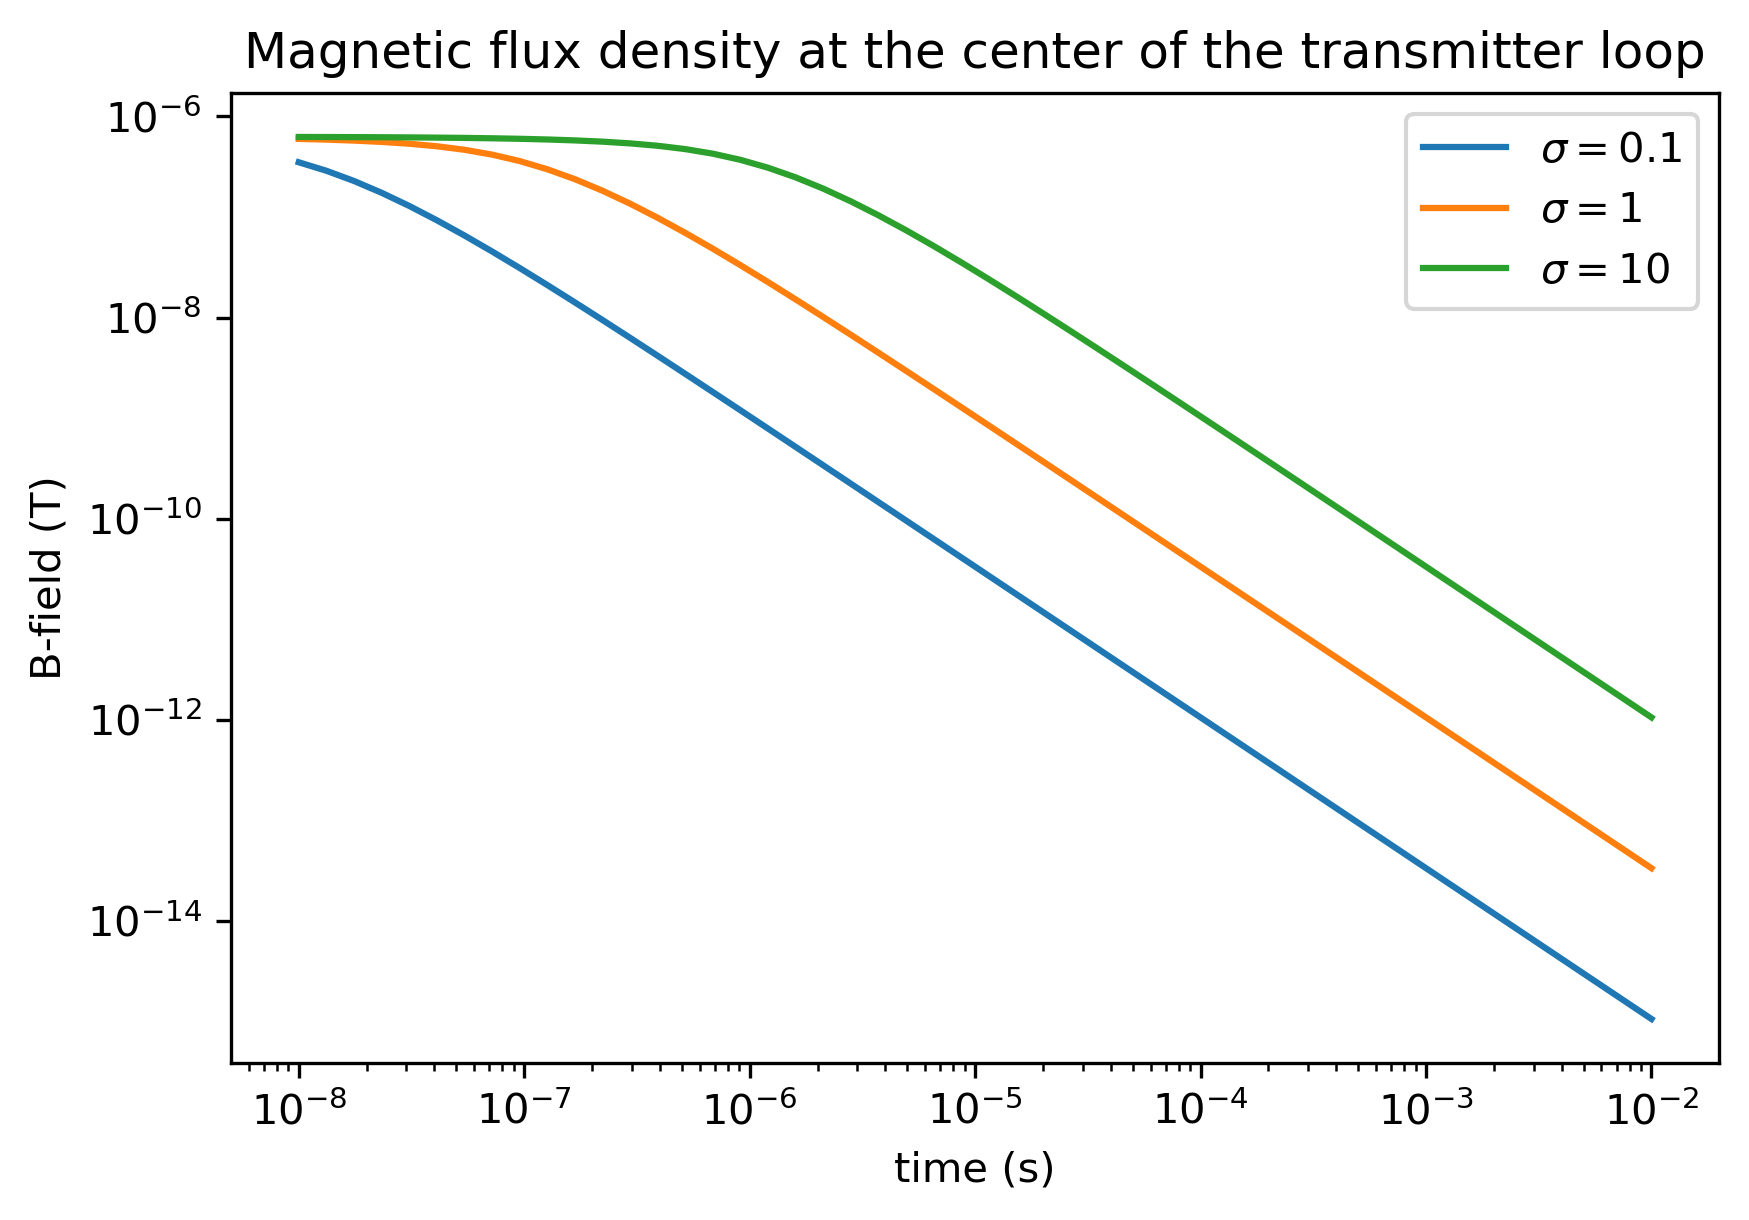

In [7]:
do_b_plot()

In a stronger resistor
* B-Field decreases faster at the start.
* B-Field is smaller.

In [8]:
def do_db_plot():
    ts = np.logspace(-8,-2)
    bz2 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=0.1)
    plt.plot(ts, -bz2, label=r'$\sigma=0.1$')
    
    bz1 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=1)
    plt.plot(ts, -bz1, label=r'$\sigma=1$')
    
    bz3 = simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(ts, sigma=10)
    plt.plot(ts, -bz3, label=r'$\sigma=10$')
    
    plt.xlabel('time (s)')
    plt.ylabel('-dB/dt (T/s)')
    plt.title('Magnetic flux density time derivative at the center of the transmitter loop')
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    plt.legend()

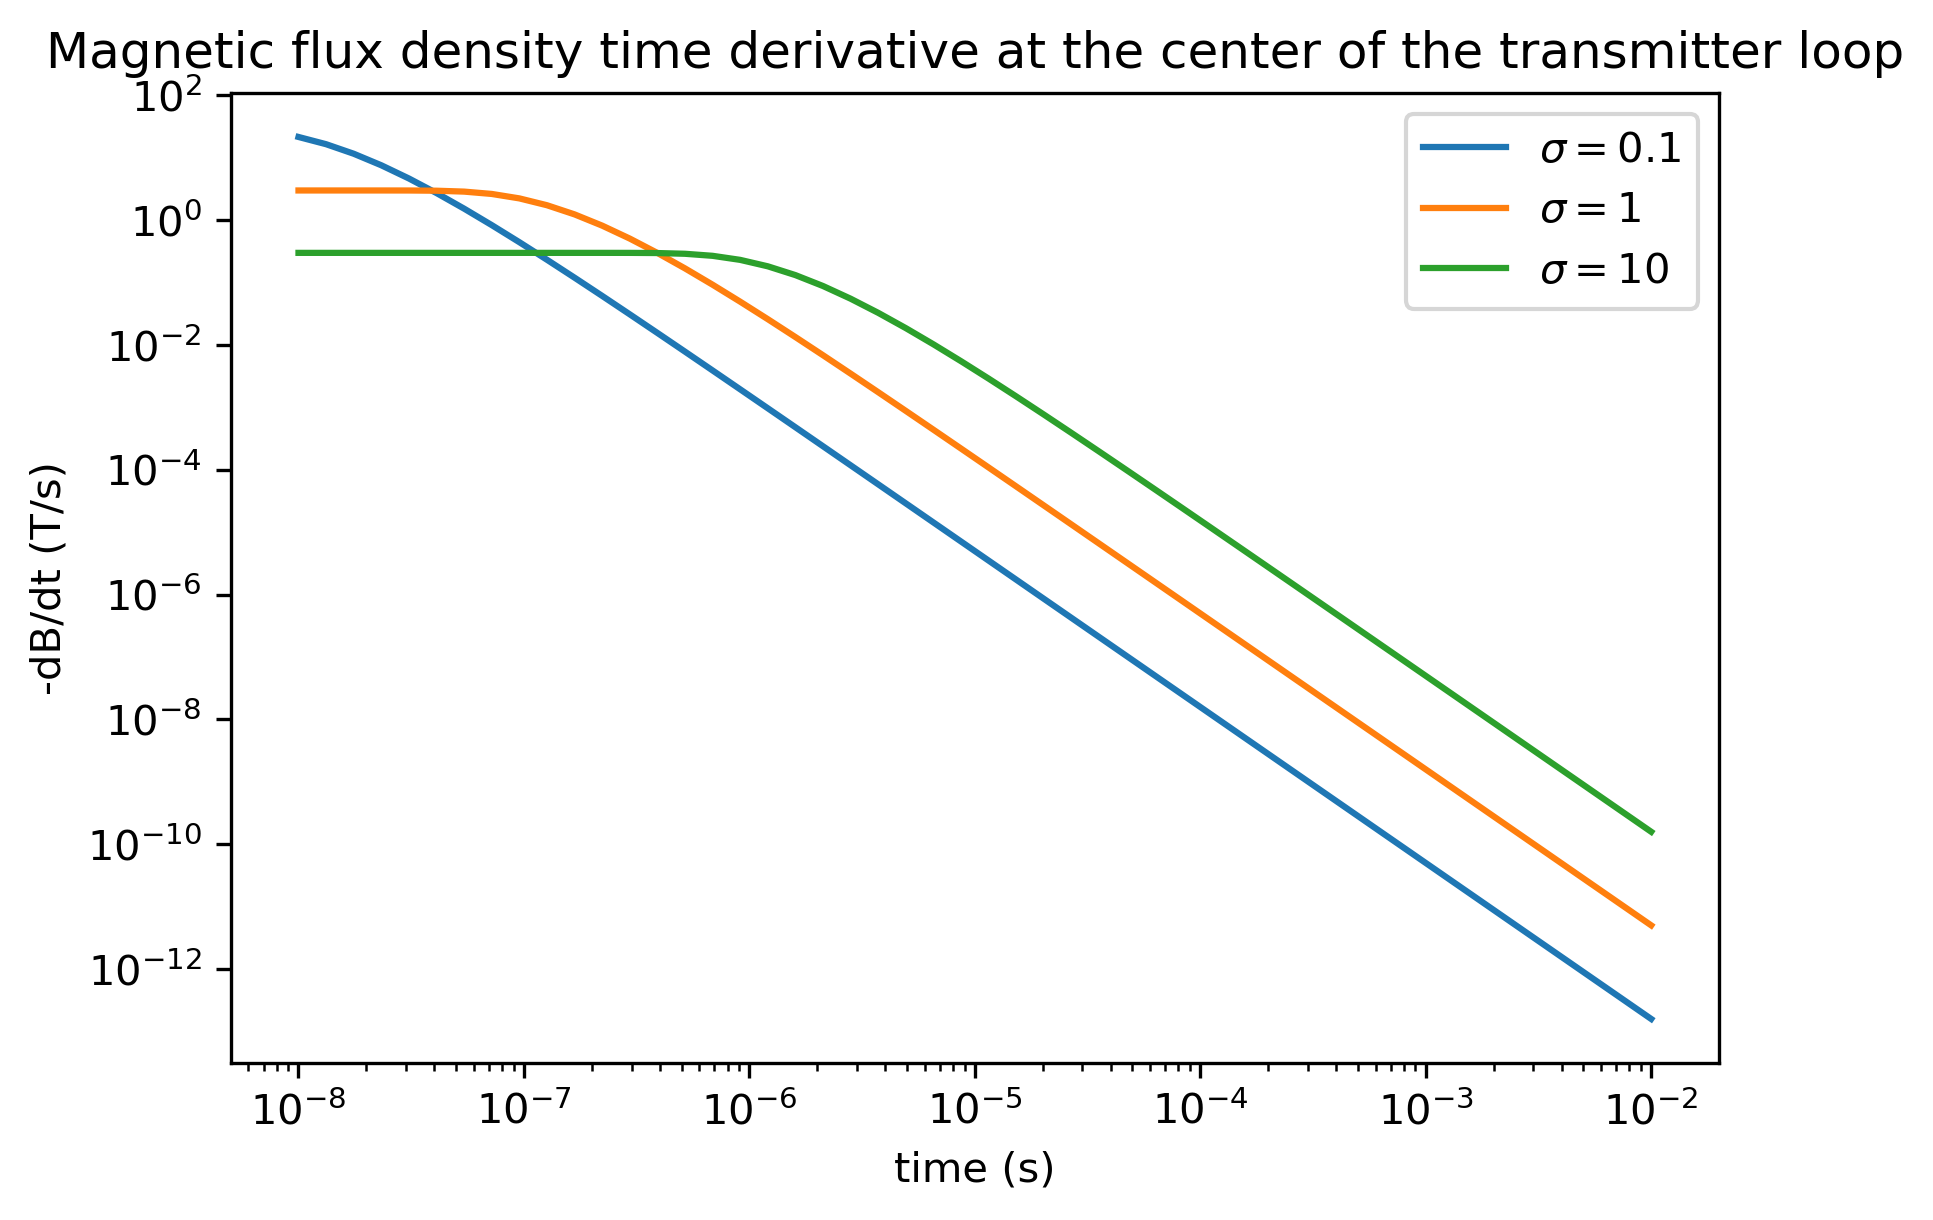

In [9]:
do_db_plot()

In a stronger resistor, since the B-field decreases faster at the start
* dBdT is larger at early times in resistors
* dBdT is larger at late times for conductors

# TDEM Survey Design

All TDEM instruments work off of the same principles:
* Transmitter waveform is abruptly terminated
* Receiver(s) "listen/s" to induced currents decay through the Earth

## Transmitters (Tx)
There are basically two aspects of the transmitter under your control:

* Shape
* Waveform

### Transmitter Shape

You have control over the shape of the transmitter.

* $\uparrow$ physical size
  * $\uparrow$ dipole moment ($\uparrow$ signal)
  * $\downarrow$ resolution
* Ease of setup
    * Ground access
    * Geometric shapes (Circle=Hard, Square=Easy)

### Waveforms

Ideal time domain waveform is a step off current:

$$ I(t) = 1 - u(t)$$

> $u(t)$ is the unit step function

In [10]:
def do_step_plot():
    plt.plot([-1, 0, 0, 1], [1, 1, 0, 0])
    plt.ylabel('I(t)')
    plt.xlabel(r'time ($\mu$s)')

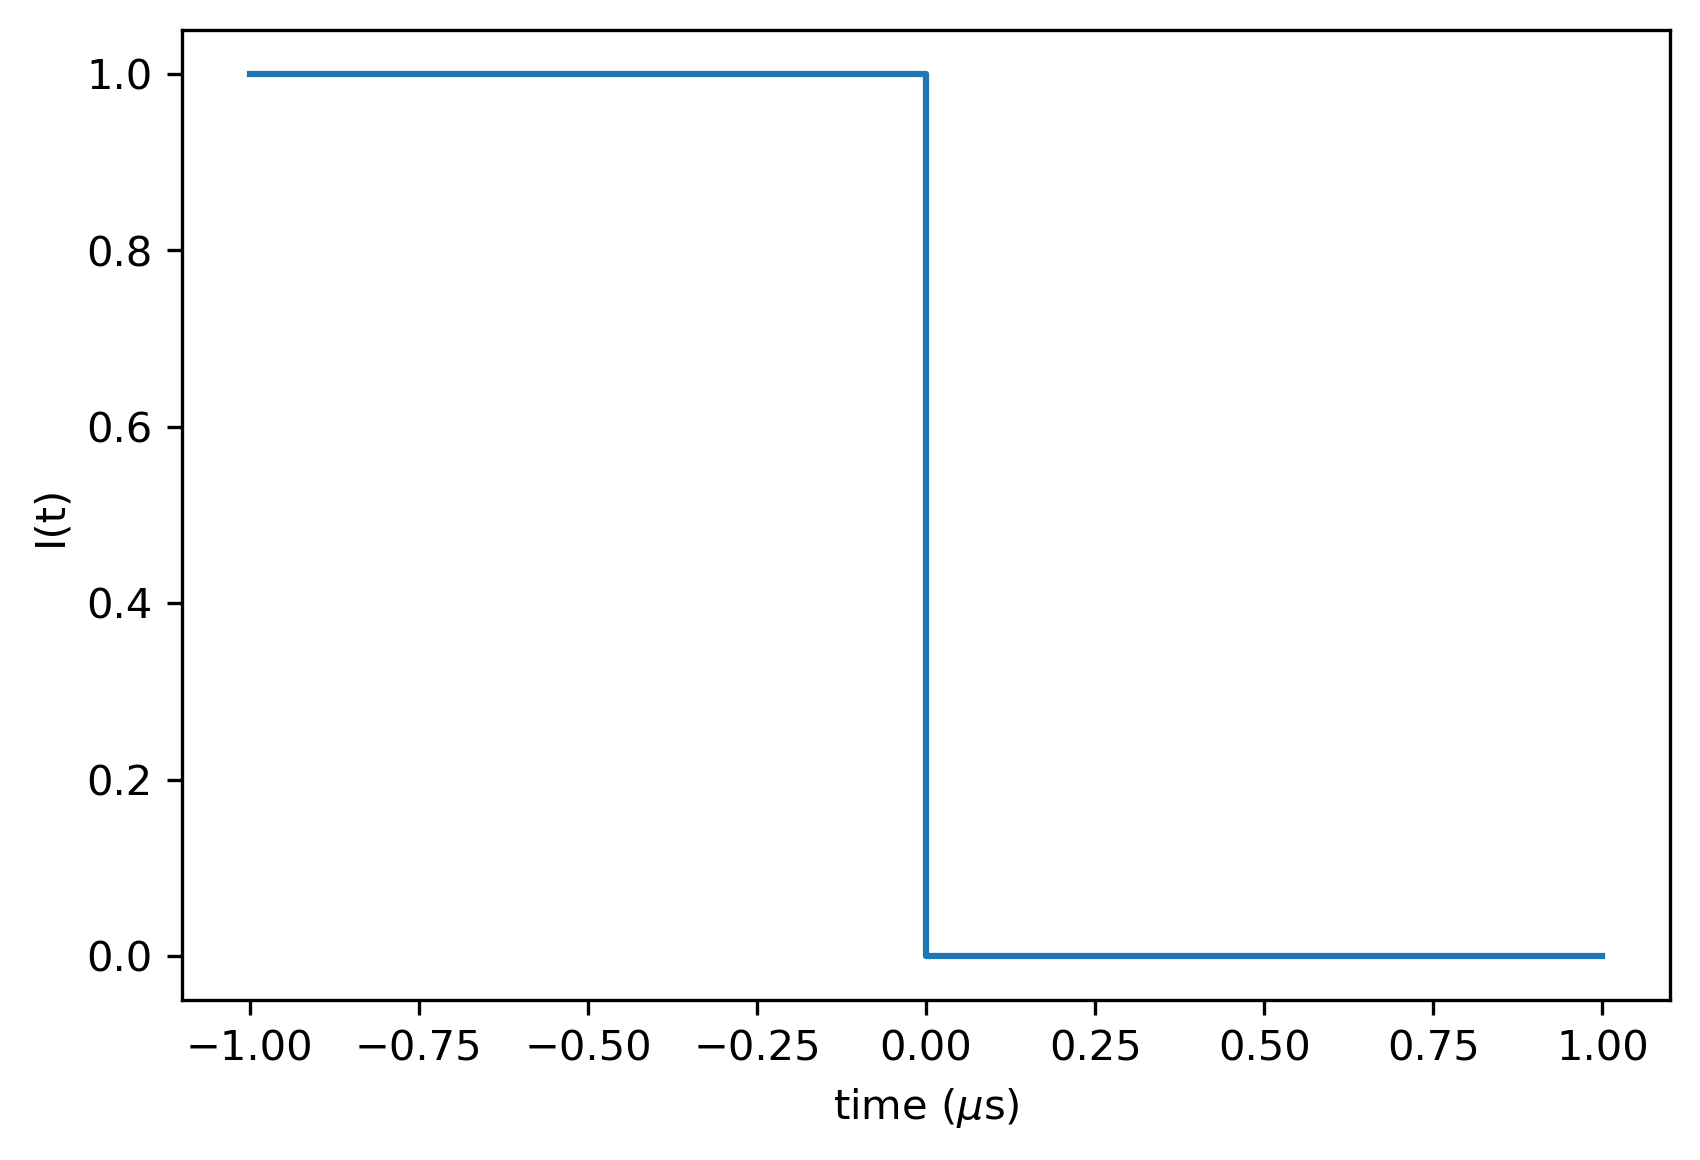

In [11]:
do_step_plot()

#### But
* Turning off electrical current is like stopping a river's current
    * It's hard to do it fast
    * Requires a lot of control
* The larger the transmitter dipole moment, the harder it is to turn off.
* Like a wave crashing against a wall.

> Turning on electrical current is even harder

#### So what?
Usually have to "gently" shutoff the current

* For near-surface problems
    * Need high resolution at early times
    * Need rapid turn-off
    * Generally leads to small loops with low currents (~1-2 Amps)
* For deep exploration:
    * larger dipole moments are required
    * Slower turn-offs are ok.
    * Leads to large loops with high currents (~10-20 Amps)

#### Other waveforms:

In [26]:
def do_ramp_plot():
    plt.plot([-10, 0, 2.5, 10], [1, 1, 0, 0])
    plt.xlabel(r'time ($\mu$s)');
    plt.title("linear ramp-off")
    plt.ylabel('I(t)')
    plt.xlabel(r'time ($\mu$s)')

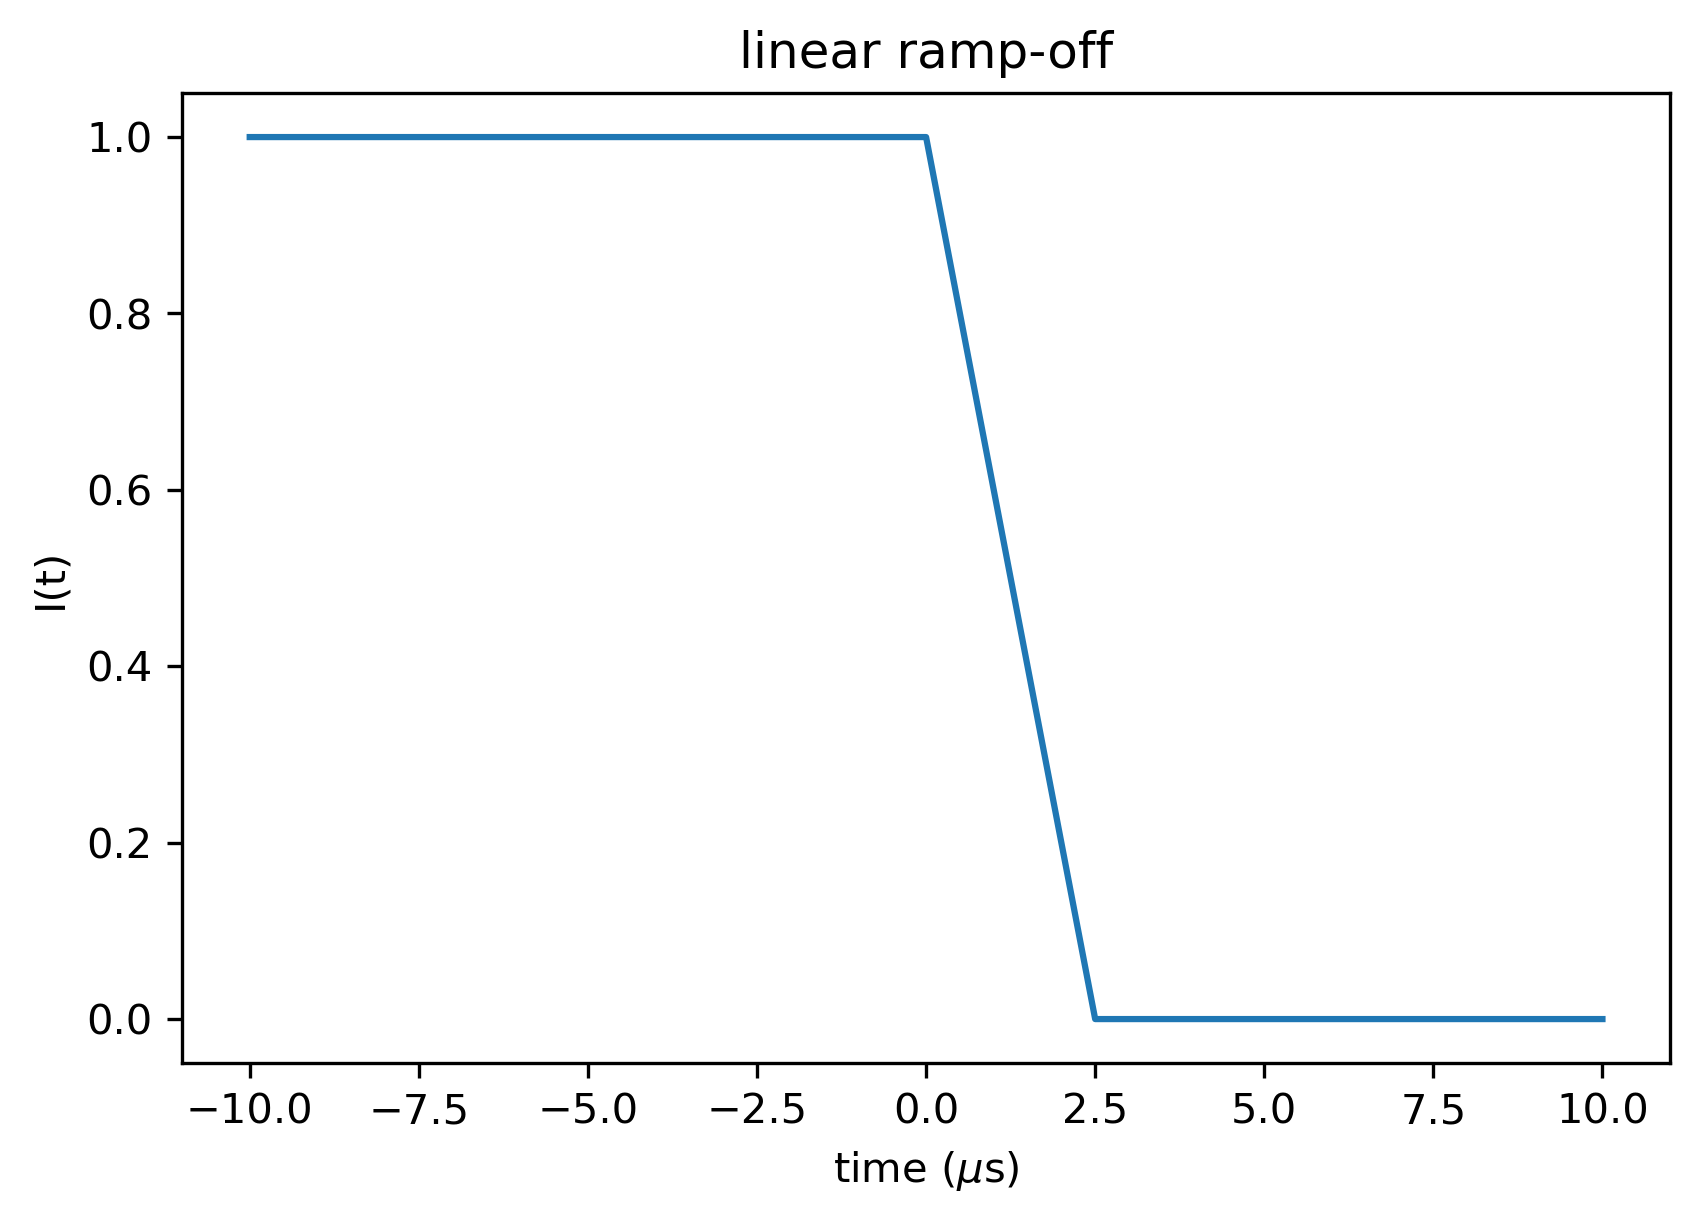

In [27]:
do_ramp_plot()

In [28]:
def do_quar_plot():
    quar_sine_ramp = tdem.sources.QuarterSineRampOnWaveform((-1E-5, 0), (0, 1E-6))
    
    ts = np.linspace(-1E-5, 1E-5, 256)
    plt.plot(ts*1E6, [quar_sine_ramp.eval(t) for t in ts])
    plt.xlabel(r'time ($\mu$s)');
    plt.title("Sine ramp on + linear ramp off")
    plt.ylabel('I(t)')
    plt.xlabel(r'time ($\mu$s)')

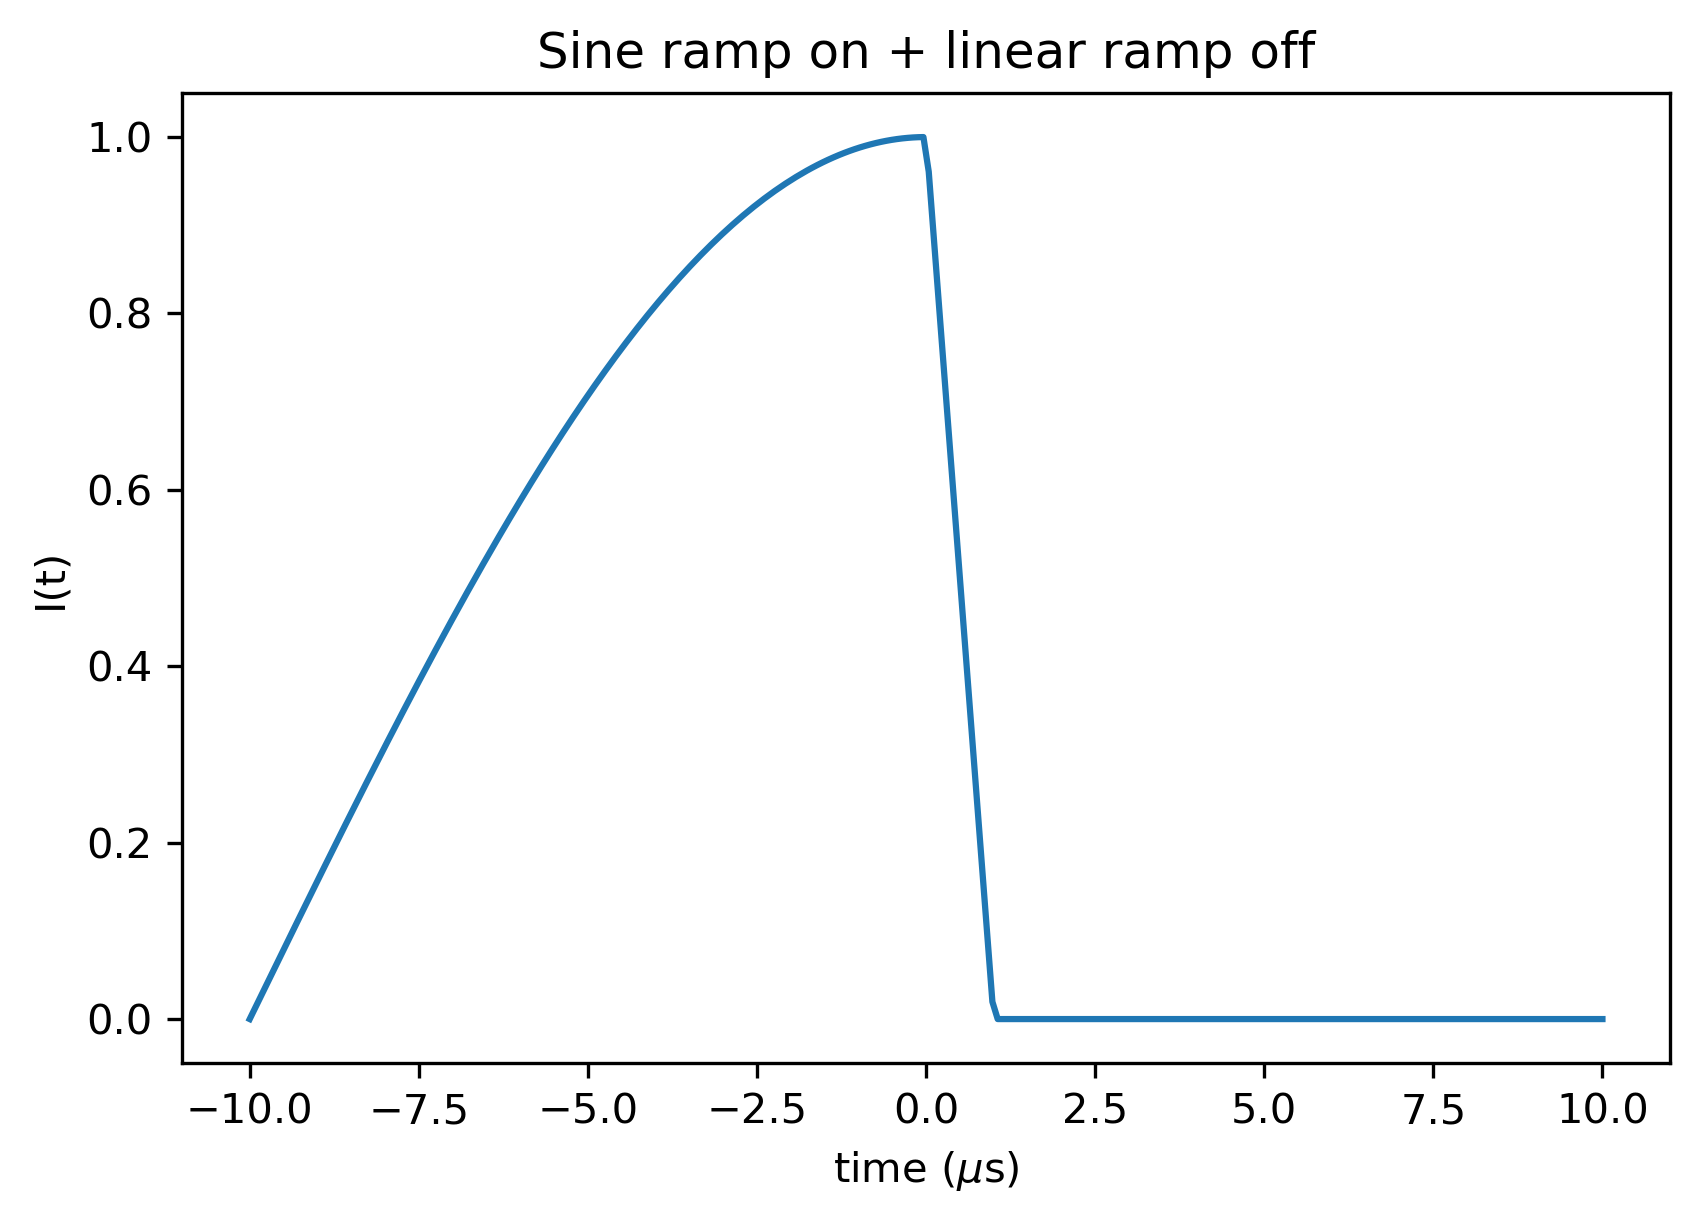

In [29]:
do_quar_plot()

In [30]:
def do_dual_plot():
    plt.plot(
        [-5, -4, -4,-2, -2, 2, 2, 4, 4, 6],
        [0, 0, 1, 1,0, 0, 4, 4, 0, 0],
    )
    plt.title("Dual moment")
    plt.ylabel('I(t)')
    plt.xlabel(r'time ($\mu$s)')

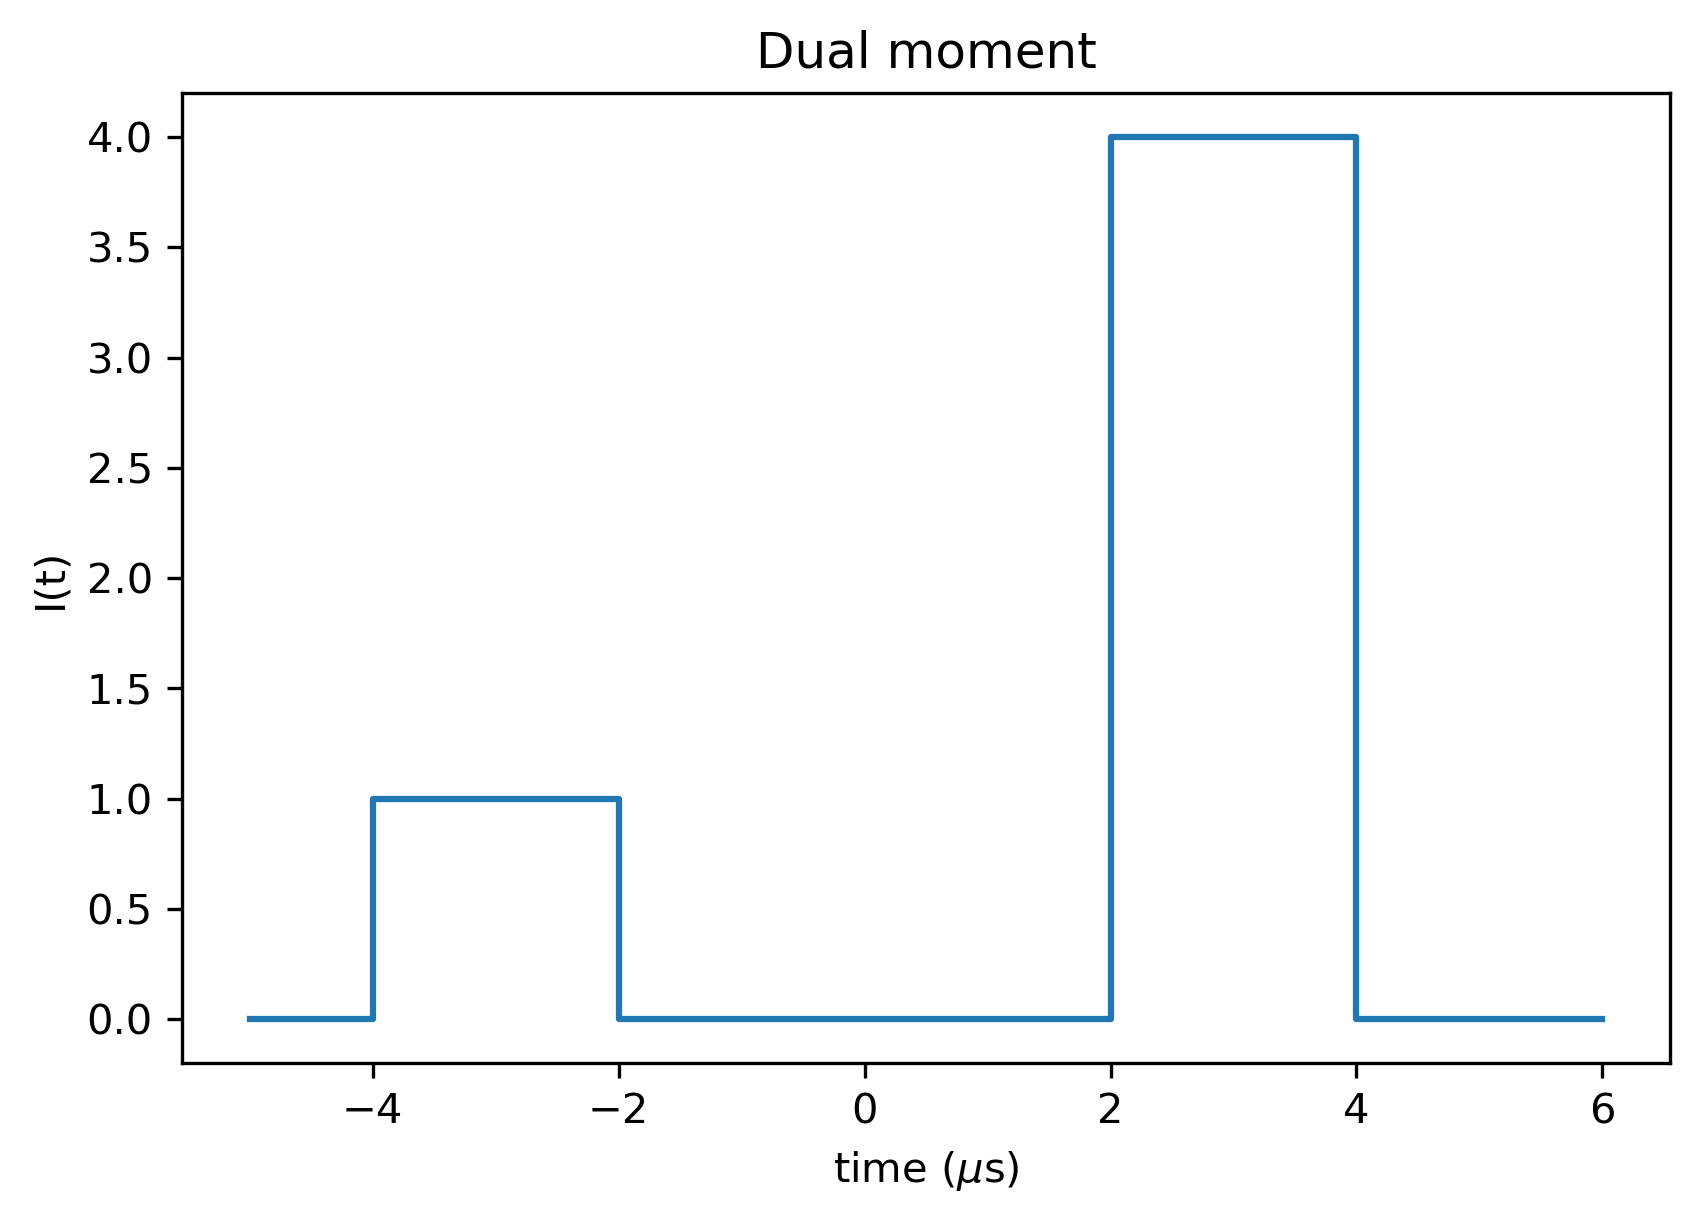

In [31]:
do_dual_plot()

... and many more

## Receivers (Rx)
* Induction based coils - $\partial B/\partial T$
* Magnetic field sensors (new tech) $B$

### Induction recievers

<div class="row">
  <div class="column">

They measure the changing magnetic flux through a loop of wire.

Thus think Integral form of Faraday's law!

$$
\newcommand{\oiint}{{\subset\!\supset} \mathllap{\iint}}
V = EMF = -\oiint_A \frac{\partial \vec{B}}{\partial t} \cdot \vec{dA}
$$

</div>
<div class="column">


![Amperes](resources/1-faraday-flux.png "B field due to a wire")
</div>
</div>

<div class='row'>
<div class='column'>
        
* Some are rigid (e.g. Geonics EM-47 & ABEM WalkTEM)
* Some are not (e.g. ABEM WalkTEM, Zonge NanoTEM)
   * Setup like the transmitter coil!
</div>
<div class='column'>

![ProTEM](resources/2-protem.jpg "ProTEM HF3D Rx")
![WalkTEM](resources/2-walktem.png "WalkTEM rigid Rx") 
</div>
</div>

* How much signal is measured depends on
    * The transmitter (magnetic moment & waveform)
    * The earth conductivity (what we're interested in)
    * The coupling between the magnetic field and the receiver

#### Coupling

We essentially measure the change in magnetic flux perpendicular to our reciever loop.

> **Remember**
> we're integrating a dot product!
> $$
\newcommand{\oiint}{{\subset\!\supset} \mathllap{\iint}}
 -\oiint_A \frac{\partial \vec{B}}{\partial t} \cdot \vec{dA}
$$

A few cases:

**Well coupled**

<div class='row'>
<div class='column'>

* All field lines are ~perpendicular to the coil $\rightarrow$ Big EMF!
</div>
<div class='column'>

![good](resources/2-good-couple.png "good coupling")
</div>
</div>

**null coupled**
<div class='row'>
<div class='column'>

* All field lines are parallel to the coil $\rightarrow$ No EMF!
</div>
<div class='column'>

![null1](resources/2-null-couple.png "null coupling")</div>
</div>

**null coupled**

<div class='row'>
<div class='column'>

* Field lines go both into and out of the coil $\rightarrow$ No EMF
</div>
<div class='column'>

![null1](resources/2-null-couple2.png "null coupling")
</div>
</div>

### Recording Electrical Signals

Important to have at least a basic understanding of how electrical signals are recorded so you can understand the options presented by instruments and what you can to expect them to do.

* A voltage is induced in the coil.
* It gets "boosted".
* It gets converted from an analogue signal to a digital signal.
* The digital signal is saved at specific times.

#### ADC (Analog to digital converter)

* Signals we measure are continuous in both time **and** amplitude.
* The incoming analog signal's amplitude get's quantized (discretize) into discrete numbers.
    * Basically rounding the amplitude
* They often have a certain number of channels (Think bits in a floating point number).


> relevant wikipedia page: https://en.wikipedia.org/wiki/Analog-to-digital_converter

> Digital Signal Analysis will give you tons of information about sampling an analog signal

In [32]:
def continuous_func(x):
    return 2*np.sin(x)**3  + np.cos(x)**2

def do_analog_plot():
    x = np.linspace(-2*np.pi, 2*np.pi, num=1024)
    plt.plot(x, continuous_func(x), label='analog signal')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('voltage')

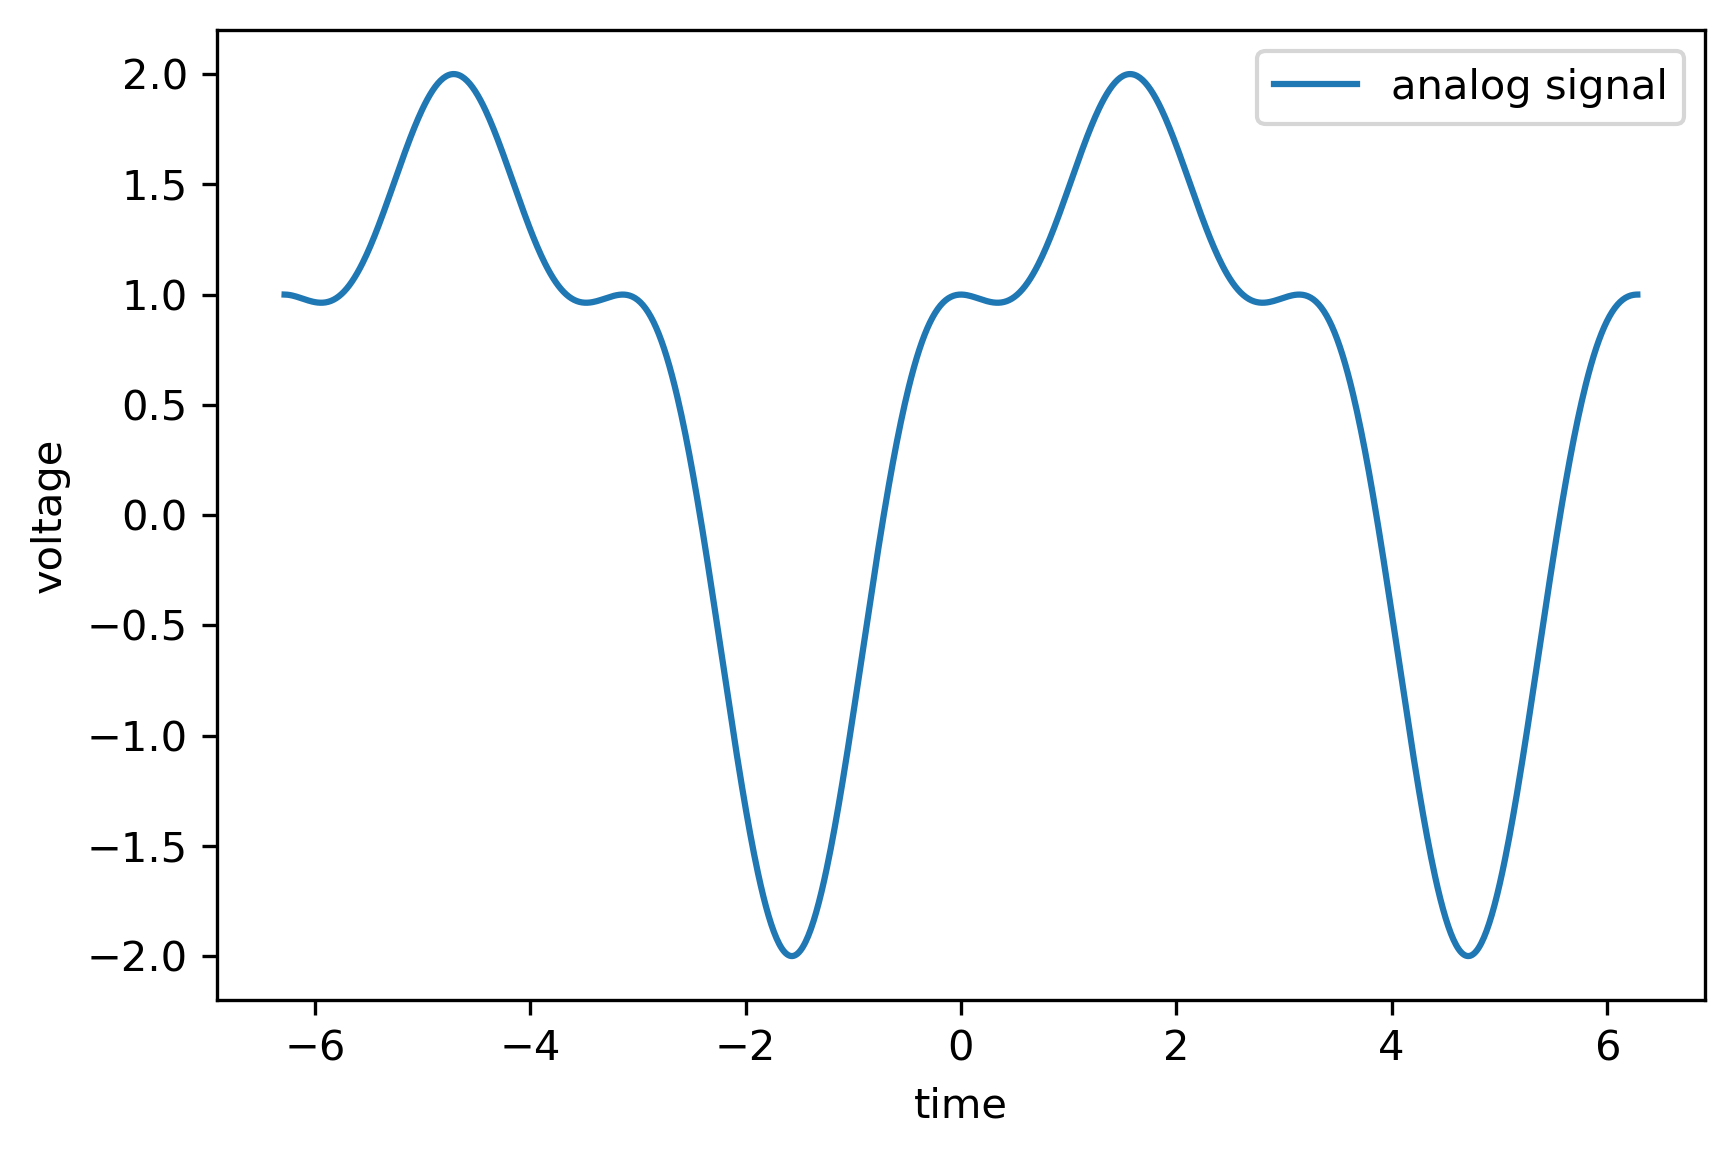

In [33]:
do_analog_plot()

In [34]:
adc_channels = np.r_[
    -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4
]

def do_analog_rails_plot():
    x = np.linspace(-2*np.pi, 2*np.pi, num=1024)
    ana = plt.plot(x, continuous_func(x), label='analog signal')
    lines = [plt.axhline(level, color='C1') for level in adc_channels]
    lines[0].set_label('ADC channels')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('voltage')

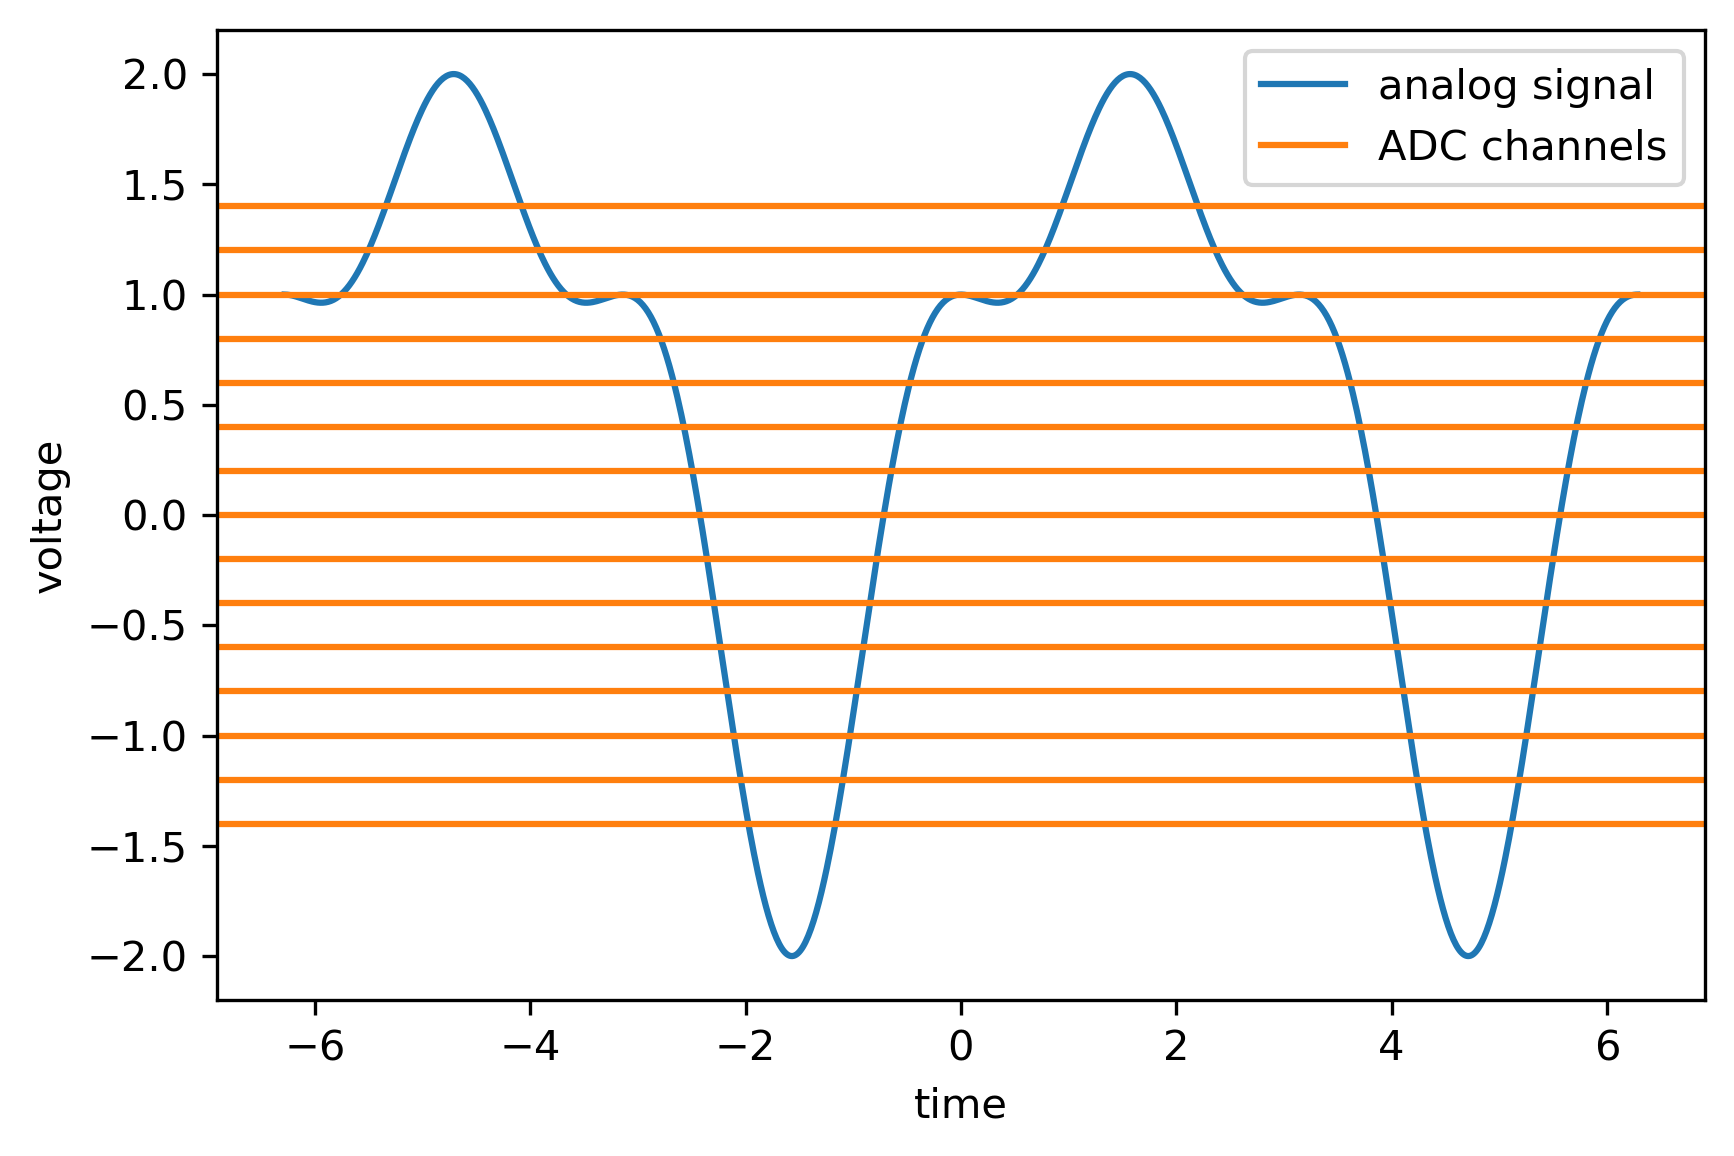

In [35]:
do_analog_rails_plot()

In [36]:
def ADC_convert(signal, channels):
    bins = np.digitize(signal, channels)
    bins = np.minimum(len(channels)-1, bins)
    return channels[bins]

def do_digital_plot():
    x = np.linspace(-2*np.pi, 2*np.pi, num=1024)
    ana = plt.plot(x, continuous_func(x), label='analog signal')
    lines = [plt.axhline(level, color='C1', alpha=0.4) for level in adc_channels]
    lines[0].set_label('ADC bins')
    quant = plt.plot(x, ADC_convert(continuous_func(x), adc_channels), color='C2', label='quantized signal')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('voltage')

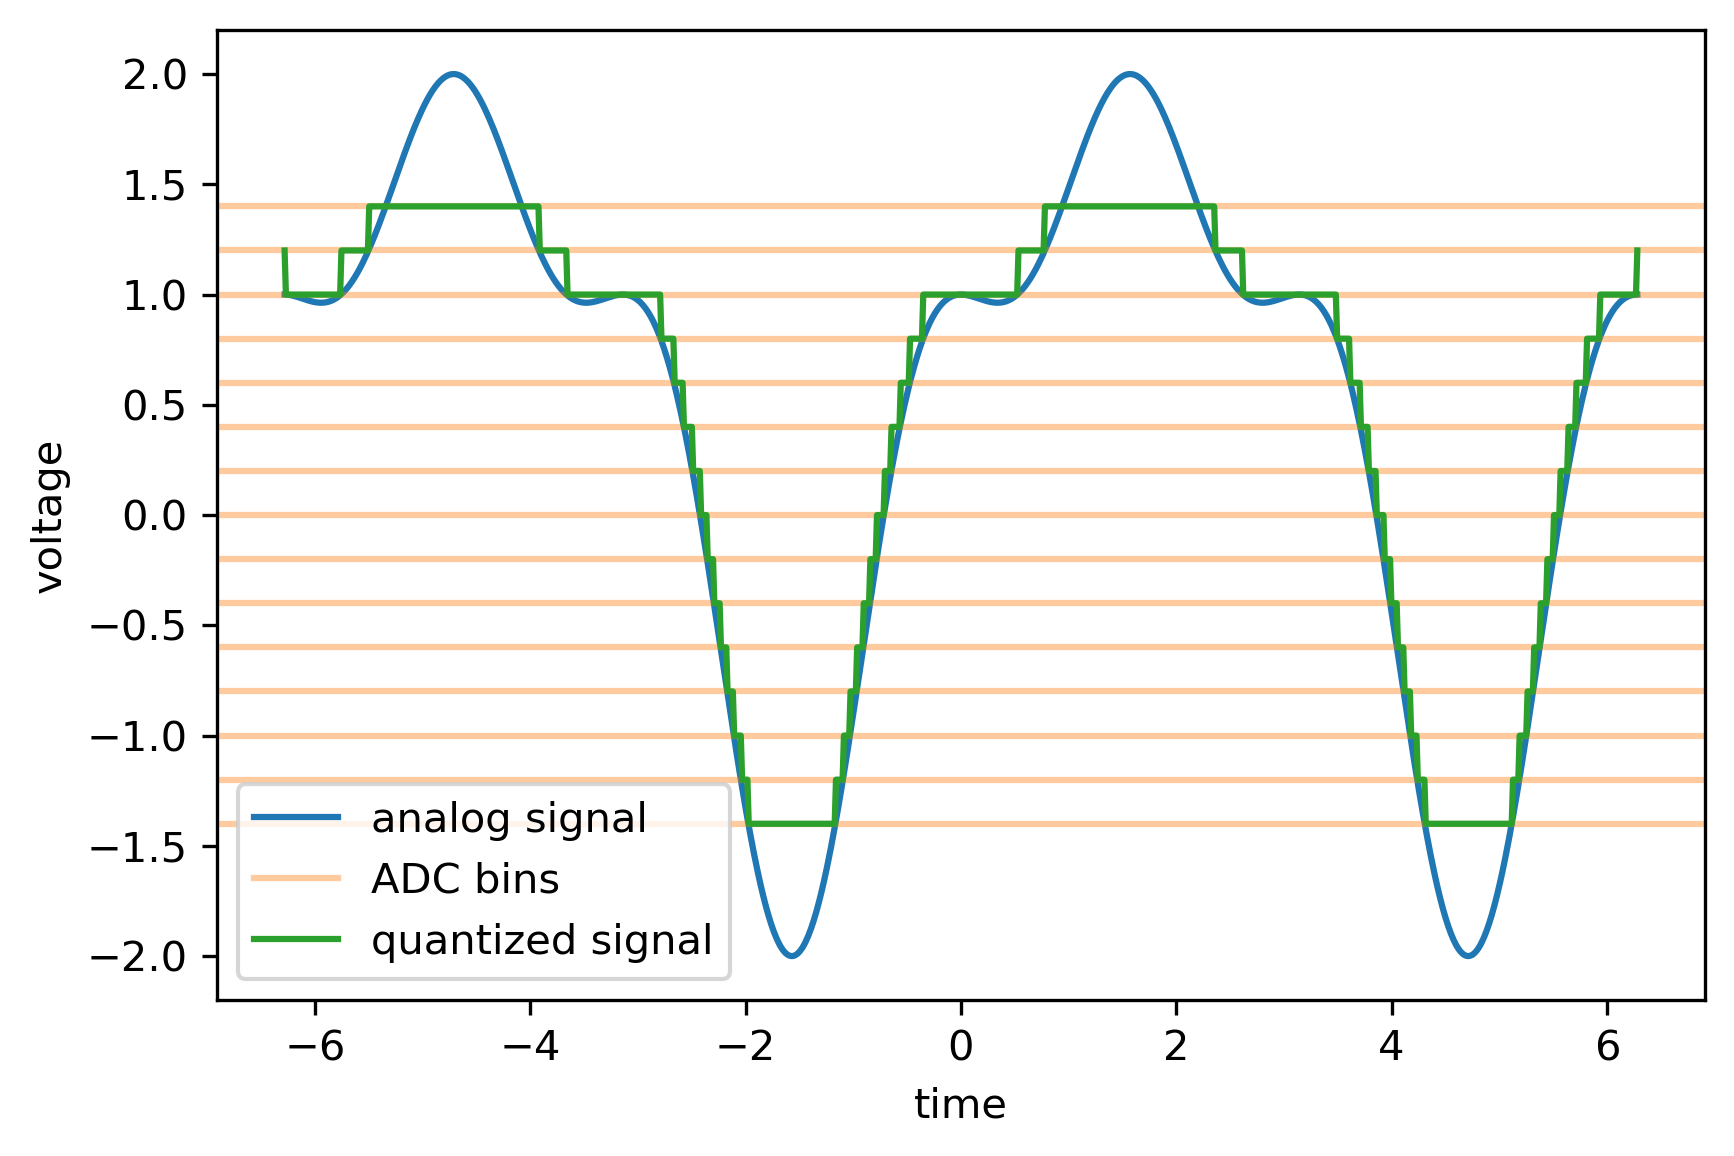

In [37]:
do_digital_plot()

Important concepts
* ADC has only a set number of values it can output
* For best resolution and accuracy, we want to use a majority of the bins but...
* Any signal outside those bins gets clipped

#### Gain

<div class='row'>
    <div class='column'>

Before the analogue signal gets converted to a digital signal we can boost it.
        
* Another electrical circuit component
* Usually gains are powers of 2
* Analogue input gets multiplied by a constant factor
    * input is signal and noise!

    </div>
    <div class='column'>

|gain| factor|
|----|-------|
| 0 |  $2^0=1$ |
| 1 | $2^1 = 2$ |
| 2 | $2^3 = 4$ |
| $\vdots$ | $\vdots$ |
| n | $2^n$|

</div>
</div>

Choosing a gain:

* Essentially boost the signal as much as possible **before** ADC
* but **can't** boost too much (don't want to go beyond the ADC's bins)
* So start with a high boost then decrease it
    * It's obvious when it hits the rails

### Time gates

* Recievers integrate the voltage before ADC as well
* Easier to measure an integrated voltage than a single voltage
* Leads to the concept of "Time Gates" in TDEM


In [38]:
def do_gate_plot():
    t = np.linspace(0, 1, 256)
    signal = lambda t: np.exp(-t/4E-1)
    
    time_windows = np.logspace(-2, 0, 21)
    
    plt.plot(t, signal(t), label='Signal')
    
    for i in range(len(time_windows)-1):
        ts = time_windows[i:i+2]
        fill = plt.fill_between(ts, np.zeros_like(ts), signal(ts), color='C1', edgecolor='k', alpha=0.3)
    fill.set_label('Time Gates')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('Time Gate integration windows')
    
    plt.legend()

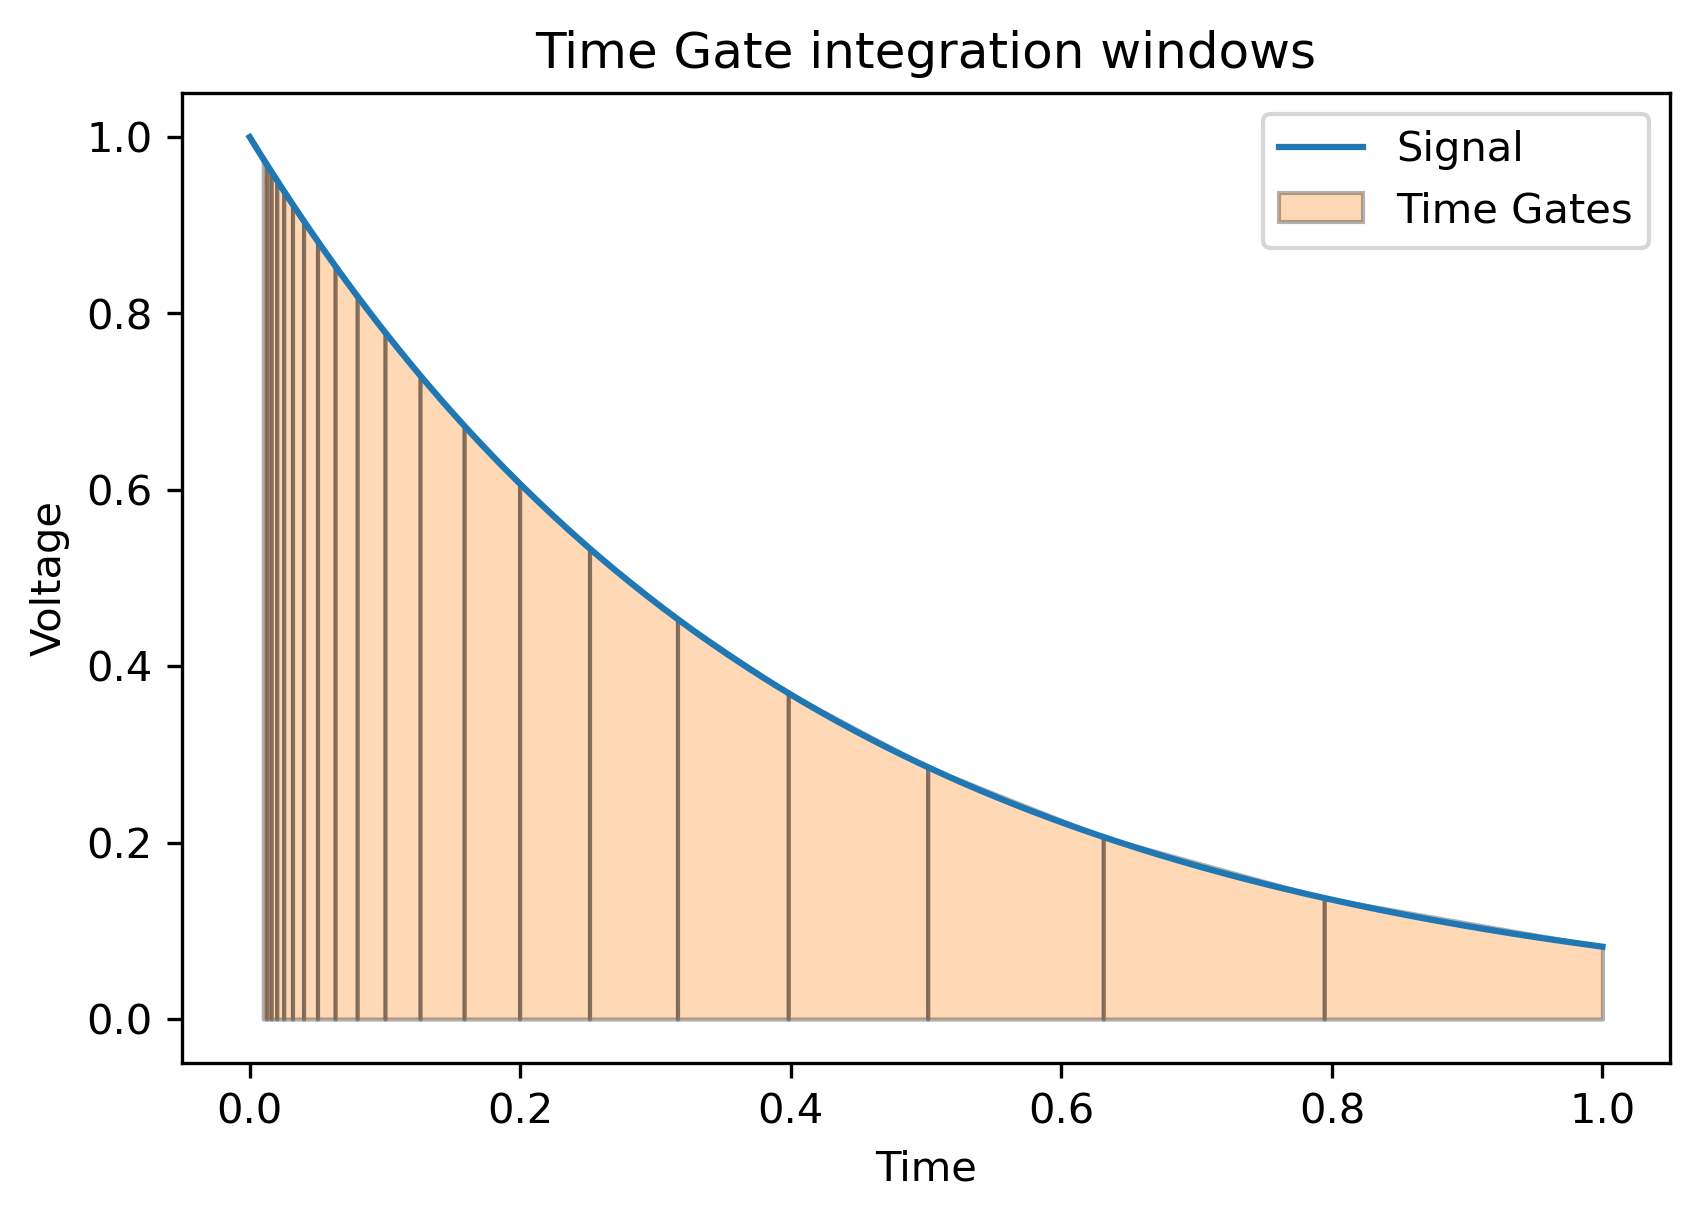

In [39]:
do_gate_plot()

* Gates have a start and end time.
    * Voltage reported is averaged over that window's width
    * Interpreted to be the voltage at the middle of the gate
* Usually spaced geometrically in time, (ProTEM, ZTEM, WalkTEM?, etc.)
    * (Each gate is a constant multiple apart from each other)
    * Gates closer together at the start where the field is changing faster
* Some systems do sample regularly though (e.g. Zonge NanoTEM)